In [84]:
import pandas as pd
import numpy as np
import re
import collections, itertools
import numpy as np
import matplotlib.pyplot as plt
import nltk
import hdbscan
import gensim

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.probability import FreqDist

from finbert_embedding.embedding import FinbertEmbedding

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import corpora
from gensim.corpora.dictionary import Dictionary

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/tatianacogne/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [85]:
import glob
list_articles = glob.glob("data/earning_call/*")
texts = []
for s in list_articles:
    with open(s) as f:
        texts.append(f.read())

In [86]:
'Number of articles', len(texts)

('Number of articles', 996)

## Processing

In [87]:
# Function that transforms a list of strings into 1 big concatenated string and vice-versa
def list_to_text(list_input, stops = []):
    text_output = ' '.join([word for word in list_input if word not in stops]) 
    return text_output

def text_to_list(text_input):
    list_output = word_tokenize(text_input)
    return list_output

In [88]:
text = 'blablabla'
# Ponctuation
text = re.sub('[^A-Za-z0-9]+', ' ', text)

# Lower all words
text = text.lower()

# Remove stopwords
stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(text)
filtered_text = [w for w in word_tokens if not w.lower() in stop_words]

print('Number of words before removing the stop words',len(word_tokens))
print('Number of words after removing the stop words',len(filtered_text))

Number of words before removing the stop words 1
Number of words after removing the stop words 1


In [89]:
# N-Gram
def ngrams_list(n):
    """
        Compute ngrams.
        
        Args:
            n (int): the number of words to words to assemble in the ngram.
        
        Returns :
            A list composed of the ngrams.
    """
    m = []
    nx_grams = ngrams(sequence = nltk.word_tokenize(text), n = n)
    for gram in nx_grams:
        m.append(gram)
    return m

In [90]:
wordnet_lemmatizer = WordNetLemmatizer()

In [91]:
# Remove most frequent and least frequent words
def remove(filtered_text, a, l, h):
    """
        Remove most and least frequent words.
        Args:
            a (list) : list on which operations should be made.
            l (float): the proportion of top l% least frequent words to remove from the numer of different words.
            h (float): the proportion of top h% most frequent words to remove from the numer of different words.
    
        Returns:
            A copy of the input text without frequent and infrequent words.
    """
    f = FreqDist(a)

    df_fdist = pd.DataFrame({'Word': f.keys(), 'Number of apparitions': f.values()})
    L= l*len(df_fdist)
    L=int(L)

    H=h*len(df_fdist)
    H=int(H)
    
    df_fdesc = df_fdist.sort_values(by='Number of apparitions', ascending=False)
    df_fasc = df_fdist.sort_values(by='Number of apparitions', ascending=True)

    most_freq_words_list = list(df_fdesc['Word'][:H])
    least_freq_word_list = list(df_fasc['Word'][:L])
    stopwords = most_freq_words_list + least_freq_word_list
    textlist_wo_extremes = list_to_text(filtered_text, stopwords)
    #text_wo_extremes = ' '.join([word for word in filtered_text if word not in stopwords]) 

    return textlist_wo_extremes

In [178]:
def processing(text):
    """Function that combien all the processing steps"""
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    x = [wordnet_lemmatizer.lemmatize(word, pos='n') for word in filtered_text]
    return remove(filtered_text, x,0.05,0.05)

In [179]:
len(texts)

996

In [180]:
#number of articles to train 
texts = [processing(x) for x in texts]

In [181]:
len(texts)

996

## FinBERT 
https://pypi.org/project/finbert-embedding/

In [115]:
finbert = FinbertEmbedding()

In [116]:
X_FinB = np.zeros((996,768))
k=0
for text in texts:
    X_FinB[k,] = finbert.sentence_vector(text)
    k+=1

In [117]:
X_FinB.shape

(996, 768)

## TFIDF
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [229]:
corpus = texts
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)
X_tfidf.shape

(996, 39166)

In [226]:
index = X_tfidf[18,].nonzero()[1]
words_of_index = [dict_index_w[x] for x in index]
score_of_index = [X_tfidf[18,x] for x in index]
x = list(zip(words_of_index,score_of_index))

In [227]:
x.sort(key=lambda x: -x[1])

In [228]:
x[:10]

[('brands', 0.2542383775954209),
 ('fabienne', 0.16481206701367782),
 ('stores', 0.14563550393070743),
 ('sales', 0.14525783813163445),
 ('lion', 0.13855801192504746),
 ('heijn', 0.13734338917806485),
 ('albert', 0.11642056206370555),
 ('porteous', 0.10987471134245189),
 ('mahamkali', 0.10987471134245189),
 ('sreedhar', 0.10987471134245189)]

In [222]:
dict_w_index = vectorizer.vocabulary_
dict_index_w = {v: k for k, v in dict_w_index.items()}

## LSA

In [232]:
# Define the number of topics or components
num_components=5

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa.fit_transform(X_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

# Print the topics with their terms
terms = vectorizer.get_feature_names()

for doc, component in enumerate(lsa.components_):
    print(doc)
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:15]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Document "+str(doc)+": ",top_terms_list)

0
Document 0:  ['us', 'customers', 'sales', 'results', 'patients', 'products', 'terms', 'costs', 'markets', 'years', 'questions', 'services', 'things', 'statements', 'margins']
1
Document 1:  ['patients', 'trials', 'studies', 'physicians', 'cells', 'therapies', 'indications', 'medical', 'unmet', 'fda', 'efficacy', 'tumors', 'enrollment', 'drug', 'programs']
2
Document 2:  ['customers', 'sales', 'solutions', 'services', 'products', 'clients', 'capabilities', 'us', 'verticals', 'devices', 'systems', 'brands', 'bookings', 'users', 'wins']
3
Document 3:  ['clients', 'loans', 'services', 'rates', 'assets', 'deals', 'originations', 'verticals', 'us', 'investments', 'companies', 'funds', 'fees', 'solutions', 'properties']
4
Document 4:  ['stores', 'brands', 'us', 'consumers', 'patients', 'terms', 'sales', 'points', 'things', 'comes', 'games', 'rates', 'categories', 'markets', 'sports']


## Randomized LSV

In [143]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X_tfidf, 
                              n_components=15,
                              n_iter=5,
                              random_state=None)

In [150]:
U[0:2,]

array([[ 2.85265917e-02, -1.53419779e-02, -2.13226599e-02,
        -1.14035037e-02, -5.77158790e-02, -1.70475826e-02,
         6.52738004e-02,  1.18647717e-02,  2.34658036e-02,
        -9.37292965e-03, -2.37268857e-02,  2.20321143e-02,
        -2.89363115e-02, -5.46746350e-02,  5.89504241e-02],
       [ 3.36316454e-02, -7.35960402e-03,  2.77837717e-02,
         4.24029257e-02, -2.91007812e-05, -7.35530136e-03,
        -1.86924254e-02, -2.62630296e-02,  1.27210643e-02,
         2.39029607e-02,  2.54943139e-02, -1.96866559e-02,
         1.21275118e-02,  2.59941349e-02, -1.70022172e-02]])

### Dimensionality reduction and clustering before topic extraction

In [118]:
embeddings = X_FinB

In [103]:
import umap.umap_ as umap

In [ ]:
reducer = umap.UMAP()

In [130]:
umap_embeddings = umap.UMAP(n_components= 15, n_neighbors=15, metric='cosine').fit_transform(embeddings)
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [131]:
'Number of clusters/topics ', len(set(cluster.labels_))

('Number of clusters/topics ', 30)

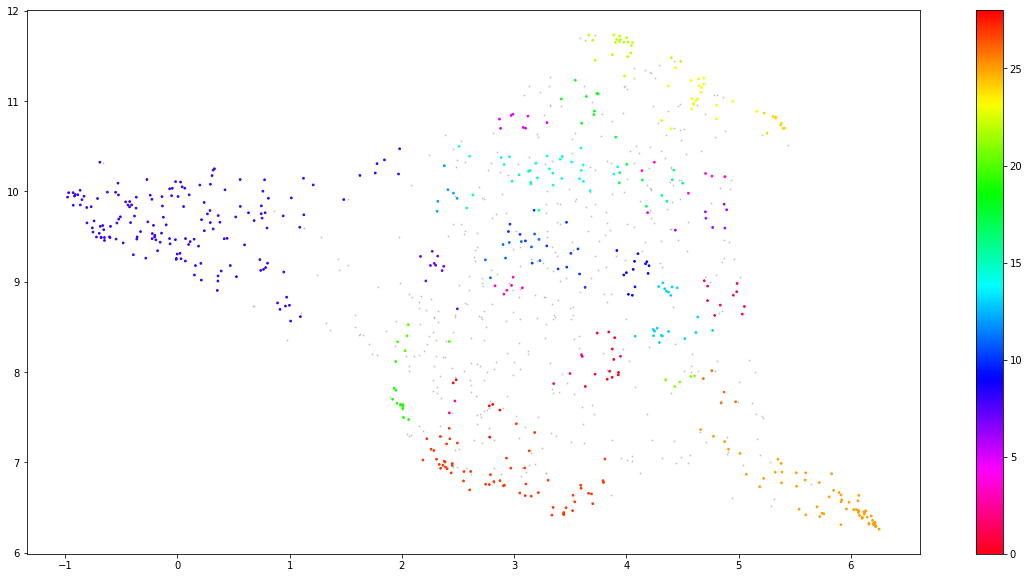

In [132]:
# Prepare data
umap_data = umap.UMAP(n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=3, cmap='hsv_r')
plt.colorbar()

In [133]:
len(texts)

996

In [134]:
docs_df = pd.DataFrame(texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [135]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(texts[:n]))

In [136]:
tf_idf.shape

(40791, 30)

In [137]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [138]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [139]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,446
9,8,162
26,25,63
28,27,60
24,23,21
14,13,21
23,22,20
15,14,19
11,10,14
10,9,13


In [140]:
k=0
for t in topic_sizes.Topic.values:
    if(t!=-1):
        top_n_words[t].sort(key=lambda x:- x[1])
        k +=1
        print('')
        print('Topic - ',k)
        for i in range(10):
            print(top_n_words[t][i][0])


Topic -  1
liver
transplantation
ascending
nochomovitz
ramakanth
lymphomas
corinne
cytokines
pes
adjuvant

Topic -  2
christoph
franck
guillaume
bombshells
tootsie
ebel
grosse
anvesh
headsets
jochen

Topic -  3
kuehne
doughnuts
suh
chapek
gulati
kannor
tienne
blosil
bragg
lemar

Topic -  4
mcdade
sparc
urbaszek
alpart
schenker
jimmy
nancy
ccap
whitehorse
lae

Topic -  5
stalls
triples
doosan
oakes
boralex
mcdonough
kingsley
enduro
fratt
yanan

Topic -  6
bogs
seymour
griffith
freshers
sgb
kenta
deysher
silvertowne
cybermetals
privates

Topic -  7
stonepine
marketwise
colucci
lemay
perma
tbi
dflaw
blasutti
brous
slager

Topic -  8
workweek
sunstone
amintore
cavanah
snowfall
aviara
treehouse
broadline
brigham
rangers

Topic -  9
lonegro
railcars
ramos
gliha
vapotherm
growgeneration
shingle
hvt
eugene
chaiken

Topic -  10
narula
altheadx
byte
esophagus
claude
biosimilars
barrett
stokes
perdoceo
kascada

Topic -  11
iheart
yandy
bressler
plby
pittman
univision
kupinski
andreev
kohn
schmae

## Linear Discriminant Analysis (LDA)
--> supervised learning !

## Latent Dirichlet Allocation (LDA)
#to do how data cleanned / words removeds

In [ ]:
!pip install gensim

In [ ]:
final_doc = [document.split() for document in corpus]

In [ ]:
dictionary = corpora.Dictionary(final_doc)
DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]
Lda_object = gensim.models.ldamodel.LdaModel

In [ ]:
lda_model_1 = Lda_object(DT_matrix, num_topics=2, id2word = dictionary)
print(lda_model_1.show_topics(num_words=10))

## BERT - Test 1

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

embeddings = model.encode(texts[:10], show_progress_bar=True)

embeddings,shape